### IMPORT LIBRARIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import grey2rgb //not used
from skimage import io
from skimage.color import rgb2gray

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical

### IMPORTING / VIEWING / PREPROCESSING DATASET 

> `DATA AUGMENTATION`

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)


# Keras ImageDataGenerator is used to take the inputs of the original data and then transform it on a random basis, returning the output resultant containing solely the newly changed data.
# Rescale is used to rescale pixel values from the range of 0-255 to the range 0-1 preferred for neural network models. Scaling data to the range of 0-1 is traditionally referred to as normalization.
# The rotation_range argument accepts an integer value between 0 to 360 and rotate the image by 0 to 360 degrees clockwise. In this method, the pixels of the image rotates.
# The zoom range for the specified float value will be [1-value, 1+value]. If you specify the zoom_range value as 0.3, then the zoom range will be [0.7, 1.3].
# Vertical flip means reversing the rows of the input image pixels while horizontal flip means reversing the column of pixel of input image.
# Validation_split allows you to randomly split a subset of your training data into a validation set, by specifying the percentage you want to allocate to the validation set





In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 20)

# The target_size is the size of your input images, every image will be resized to this size
# The 'binary' class mode gives you a number of each class. For example if your dataset has 3 class A, B, C the target data will be 0 for class A, 1 for B and 2 for C. 
# The categorical gives you one hot encoding, (1, 0, 0) for A, (0, 1, 0) for B and (0, 0, 1) for C.
# The batch size is a number of samples processed before the model is updated.
# subset ?





Found 4106 images belonging to 4 classes.


In [ ]:
len(train_dataset[1])

2

In [ ]:
len(train_dataset[0][0])

20

In [ ]:
len(train_dataset[0][0][0])

224

In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 20)

Found 254 images belonging to 4 classes.


In [ ]:
len(train_dataset[0][0][1])

224

100%|██████████| 5/5 [00:19<00:00,  3.89s/it]


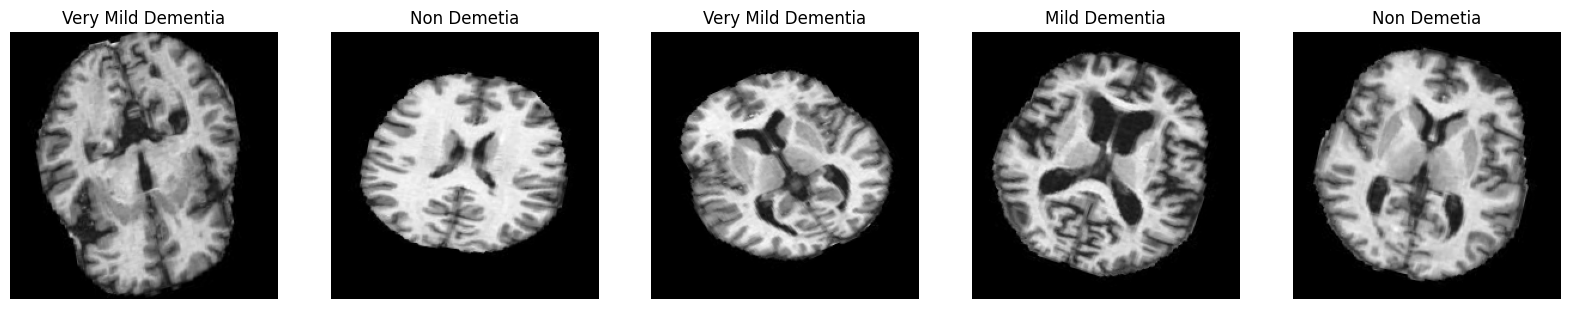

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(20)
    ax[i].imshow(train_dataset[rand1][0][rand2])             
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [ ]:
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

# VGG-16 is a convolutional neural network that is 16 layers deep
# the shape of the input data provided to the Keras model while training. 
# default input size for this model is 224x224
# include_top: whether to include the 3 fully-connected layers at the top of the network
# weights="imagenet" indicates that we want to use the pre-trained ImageNet weights for the respective model.


In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

# Trainable to False moves all the layer's weights from trainable to non-trainable. This is called "freezing" the layer: the state of a frozen layer won't be updated during training 
# (either when training with fit() or when training with any custom loop that relies on trainable_weights to apply gradient updates).

In [ ]:
# Building Model

model=Sequential()
# Sequential API is simply arranging the Keras layers in a sequential order.
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Model Summary

model.summary()
# The model summary displays the name of the model, the model type, and the model formula.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              51382272  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [ ]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),  
      tensorflow.keras.metrics.AUC(name='auc')]

model.compile(loss='categorical_crossentropy',
              metrics=METRICS,
              optimizer=OPT)

In [ ]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 2,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/2
206/206 [==============================] - ETA: 0s - loss: 1.3579 - accuracy: 0.7498 - precision: 0.4994 - recall: 0.4345 - auc: 0.7731 
Epoch 1: val_auc improved from -inf to 0.84028, saving model to ./best_weights.hdf5
206/206 [==============================] - 2616s 13s/step - loss: 1.3579 - accuracy: 0.7498 - precision: 0.4994 - recall: 0.4345 - auc: 0.7731 - val_loss: 0.9550 - val_accuracy: 0.7618 - val_precision: 0.5273 - val_recall: 0.4567 - val_auc: 0.8403
Epoch 2/2
206/206 [==============================] - ETA: 0s - loss: 1.0452 - accuracy: 0.7825 - precision: 0.5777 - recall: 0.4827 - auc: 0.8207 
Epoch 2: val_auc improved from 0.84028 to 0.85589, saving model to ./best_weights.hdf5
206/206 [==============================] - 2538s 12s/step - loss: 1.0452 - accuracy: 0.7825 - precision: 0.5777 - recall: 0.4827 - auc: 0.8207 - val_loss: 0.8964 - val_accuracy: 0.7913 - val_precision: 0.5897 - val_recall: 0.5433 - val_auc: 0.8559


In [ ]:
''' # Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show() '''

In [ ]:
''' # Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show() '''

In [ ]:
test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimer_s Dataset/test',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 20)

Found 1279 images belonging to 4 classes.


In [ ]:
pred_labels = model.predict(test_dataset)

In [ ]:
''' def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
              ) '''

In [ ]:
CLASSES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

NameError: ignored

In [ ]:
scores = model.evaluate_generator(test_dataset)
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])